### Multicollinearity

SPY is an ETF that tracks S&P 500. 

We shall run a multiple linear regression model to find if the returns of SPY can be predicted using the previous day's returns of following indices.
* S&P500
* Russell 2000
* NASDAQ Composite

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.api import OLS, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.api import influence_plot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
import warnings

warnings.filterwarnings("ignore")
sns.set()

In [2]:
data = yf.download(["^GSPC", "^RUT", "^IXIC", "SPY"], start="2020-01-01")["Adj Close"]

df = (
    data
    .resample("10D")
    .last()
    .apply(lambda x: np.log(x/x.shift(1))) #compute daily log-returns
    .apply(lambda x: x.shift(1) if x.name != "SPY" else x) #shift the regressors with lag of 1 day
    .dropna()
)

df.columns = ["S&P500_returns", "R2000_returns", "NASDAQ_returns", "SPY_returns"]

[*********************100%***********************]  4 of 4 completed


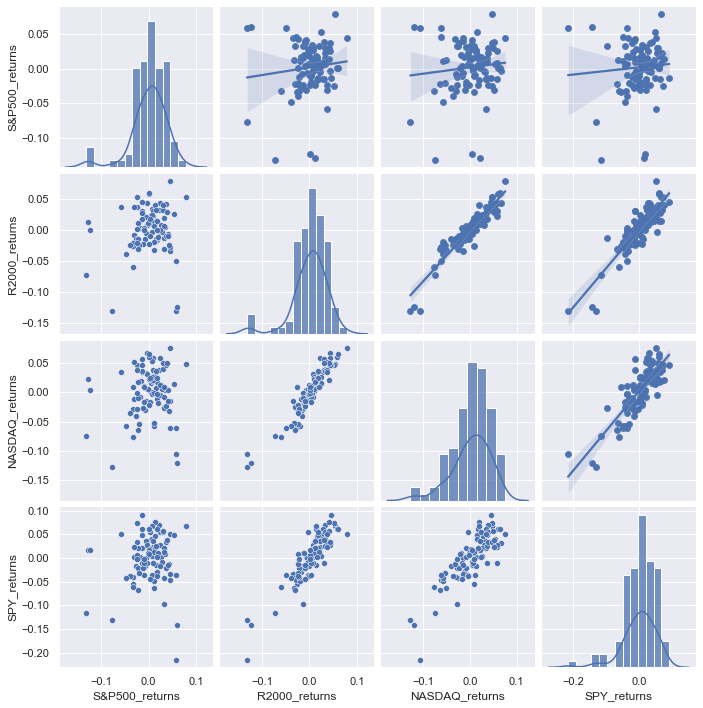

In [3]:
plot = sns.pairplot(df)
plot.map_upper(sns.regplot)
plot.map_diag(sns.kdeplot);

Text(0.5, 1.0, 'Correlation plot of independent variables')

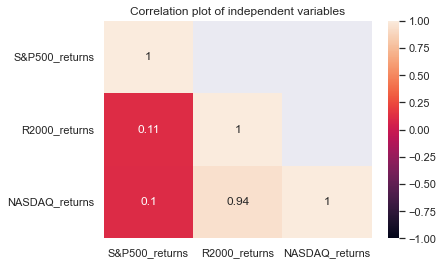

In [4]:
corr = df.drop(columns="SPY_returns").corr()

sns.heatmap(corr, annot=True, mask=np.triu(corr, k=1), vmin=-1, vmax=1)

plt.title("Correlation plot of independent variables")

From the correlation heatmap, Russell 2000's returns are highly correlated with NASDAQ returns.

In [5]:
X = df.drop(columns="SPY_returns")
y = df["SPY_returns"]
print(OLS(y,add_constant(X)).fit().summary())

                            OLS Regression Results                            
Dep. Variable:            SPY_returns   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     107.1
Date:                Mon, 05 Sep 2022   Prob (F-statistic):           6.70e-30
Time:                        09:11:29   Log-Likelihood:                 223.93
No. Observations:                  96   AIC:                            -439.9
Df Residuals:                      92   BIC:                            -429.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0013      0.002     -0.

The p-value of NASDAQ returns is not significant. We shall further check multicollinearity issue with Variance Inflation Factor (VIF).

VIF is computed by regressing dependent variable against other dependent variables and computing their $R^2$

$
\text{VIF} = \normalsize{\frac{1}{1 - R^2}}
$

Regressors with VIF greater than 5 has strong correlation

In [6]:
(
    pd.DataFrame([variance_inflation_factor(X, i) for i in range(len(X.columns))], X.columns)
    .rename(columns={0:"VIF"})
)

,VIF
S&P500_returns,1.012922
R2000_returns,8.900886
NASDAQ_returns,8.887225


The above table confirms high multi-collinearity between Russell 2000 and NASDAQ returns.

We shall drop NASDAQ returns from the regressors and print the summary statistics.

In [7]:
X = df.drop(columns=["SPY_returns","NASDAQ_returns"])
y = df["SPY_returns"]

print(OLS(y,add_constant(X)).fit().summary())

                            OLS Regression Results                            
Dep. Variable:            SPY_returns   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     162.3
Date:                Mon, 05 Sep 2022   Prob (F-statistic):           4.64e-31
Time:                        09:11:29   Log-Likelihood:                 223.93
No. Observations:                  96   AIC:                            -441.9
Df Residuals:                      93   BIC:                            -434.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0013      0.002     -0.

In [8]:
(
    pd.DataFrame([variance_inflation_factor(X, i) for i in range(len(X.columns))], X.columns)
    .rename(columns={0:"VIF"})
)

,VIF
S&P500_returns,1.012921
R2000_returns,1.012921


The multicollinearity issue is mitigated by dropping NASDAQ index, which was highly correlated with Russell 2000

### Skewness

From the pairplot, we can see both dependent and independent variables are left skewed.

We shall consider the dependent variable (SPY_returns) to address skewness.

In [9]:
def skewness_test(data):
    '''
    Input: pandas series or numpy array
    
    Plots histogram and a qq-plot against a normal distribution.
    
    Performs skewtest and prints the statistic and p-values (using scipy.stats.skewtest)
    '''
    plt.figure(figsize=(14, 5))
    ax1 = plt.subplot(121)
    sns.histplot(data, kde=True, stat="proportion")
    
    ax2 = plt.subplot(122)
    stats.probplot(data, dist="norm", plot=plt)
    
    stat, pvalue = stats.skewtest(data)
    if pvalue > 0.05:
        print("Distribution is not skewed")   
    else:
        print("The data is a skewed distribution")
    print(f"z-score: {stat}, p-value: {pvalue}")

The data is a skewed distribution
z-score: -4.4444494021198455, p-value: 8.811724223216786e-06


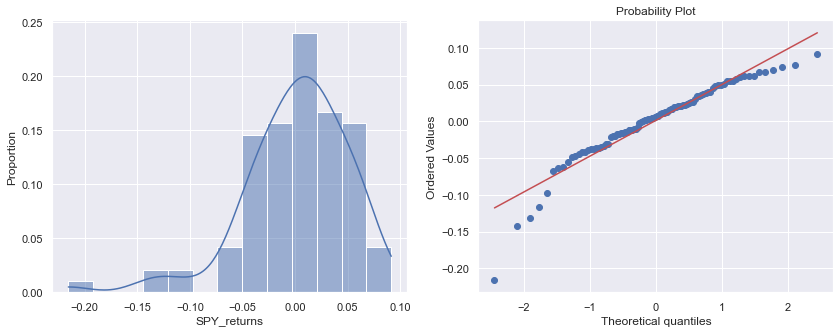

In [10]:
skew_data = df["SPY_returns"]
skewness_test(skew_data)

The above plots and statistic confirms that SPY_returns is indeed a skewed distribution.

Let's apply a box-cox transformation and check if it removes skewness.

Distribution is not skewed
z-score: -0.056586825324653124, p-value: 0.9548743295963166


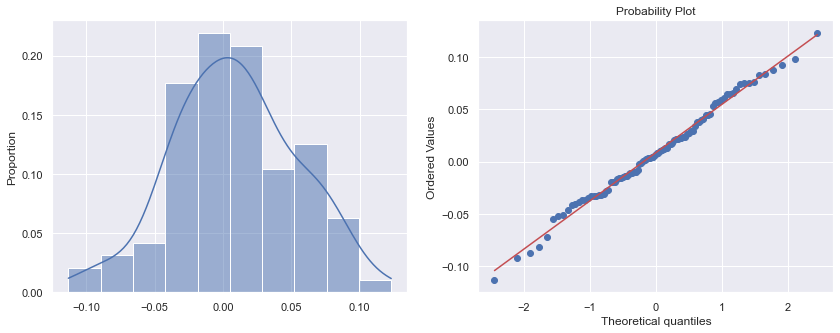

In [11]:
transformed_data = stats.boxcox(skew_data+1)[0]
skewness_test(transformed_data)

By applying box-cox power transformation, we were able to remove skewness.

Let's now model a multiple regression against the transformed data and compare with previous model results.

In [12]:
model = OLS(transformed_data, add_constant(X)).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     101.6
Date:                Mon, 05 Sep 2022   Prob (F-statistic):           4.02e-24
Time:                        09:11:30   Log-Likelihood:                 216.50
No. Observations:                  96   AIC:                            -427.0
Df Residuals:                      93   BIC:                            -419.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0063      0.003      2.

### Overfitting

As the returns of SPY is highly correlated with R2000, we shall try a tree-based model and try to improve the score.

We shall also do a train-test split to evaluate the model performance on test data.

In [61]:
depth=10
dt_overfit = DecisionTreeRegressor(max_depth=depth).fit(X_train,y_train)
print(f"Decision Tree Regressor with maximum depth {depth}")
print("-"*45)
print(f"r2 score on training dataset: {round(r2_score(y_train, dt_overfit.predict(X_train)),2)}")
print(f"r2 score on test dataset: {round(r2_score(y_test, dt_overfit.predict(X_test)),2)}")

Decision Tree Regressor with maximum depth 10
---------------------------------------------
r2 score on training dataset: 0.99
r2 score on test dataset: 0.61


The difference in the $R^2$ score between training and testing dataset is huge, which suggests the model is overfitted.
A good model should be able to generalize to unseen data.

The model has low bias and high variance.

In [63]:
depth=3
dt = DecisionTreeRegressor(max_depth=depth).fit(X_train,y_train)
print(f"Decision Tree Regressor with maximum depth {depth}")
print("-"*45)
print(f"r2 score on training dataset: {round(r2_score(y_train, dt.predict(X_train)),2)}")
print(f"r2 score on test dataset: {round(r2_score(y_test, dt.predict(X_test)),2)}")

Decision Tree Regressor with maximum depth 3
---------------------------------------------
r2 score on training dataset: 0.8
r2 score on test dataset: 0.76


By reducing the maximum depth, the $R^2$ on training data has significantly reduced, but the model can now generalize well on the unseen data.

* A model can easily overfit when it is not tuned with proper hyperparameters.

* There is always a trade-off between bias and variance and a good model should find the optimal balance between them.